# Humidity comparison: Hygrometer and isotope analyzer

During EUREC⁴A and ATOMIC the P3 made two _in situ_ measurements of humidity, one  
with the normal chilled-mirror hygrometer, and one with a cavity ring down spectrometer.
The spectrometer's main purpose was to measure isotopes of water vapor but it's
good for the total humidty as well.

For this example we need to plot some `xarray` datasets from the catalog.

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import pathlib
plt.style.use(pathlib.Path("./mplstyle/book"))
import colorcet as cc
%matplotlib inline

import eurec4a
cat = eurec4a.get_intake_catalog(use_ipfs="QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N")

We'll create a combined data with relative humidity from the aircraft hygrometer
("fl" means "flight level") and the water vapor isotope analyzer ("iso")
from a single flight. Drop (remove) times when the aircraft is on the ground.

In [2]:
fl = cat.P3.flight_level["P3-0119"].to_dask()
pi = cat.P3.isotope_analyzer.water_vapor_1hz["P3-0119"].to_dask()
rhs = xr.Dataset({"press" :fl["press"],
                  "alt"   :fl["alt"],
                  "rh_p3" :fl["RH"],
                  "rh_iso":pi["rh_iso"]}).compute()
rhs = rhs.where(rhs.alt > 80., drop = True)

/home/runner/miniconda3/envs/how_to_eurec4a/lib/python3.13/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


/home/runner/miniconda3/envs/how_to_eurec4a/lib/python3.13/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


Adriana Bailey from NCAR, who was responsible for the isotope analyzer, finds
that while the two instruments agree most of the time, the hygrometer is subject
to both overshooting (e.g. when the measured signal surpasses the expected value
following a rapid rise in environmental water vapor concentration) and ringing
(i.e. rapid oscillations around the expected value) during rapid and large changes in
water vapor concentration.

Here are two figures to illustrate the problem and shows why you'd want to use the
water vapor measurements from the isotope analyzer when they're available. The top
panel combines data from two profiles and shows large excursions in the water vapor
measured by the hygrometer. The lower panel shows that most measurements agree
well but it's clear that it's better to use the the isotope analyzer measurements of
humidity during the experiment.

Text(0, 0.5, 'Picarro relative humidity (%)')

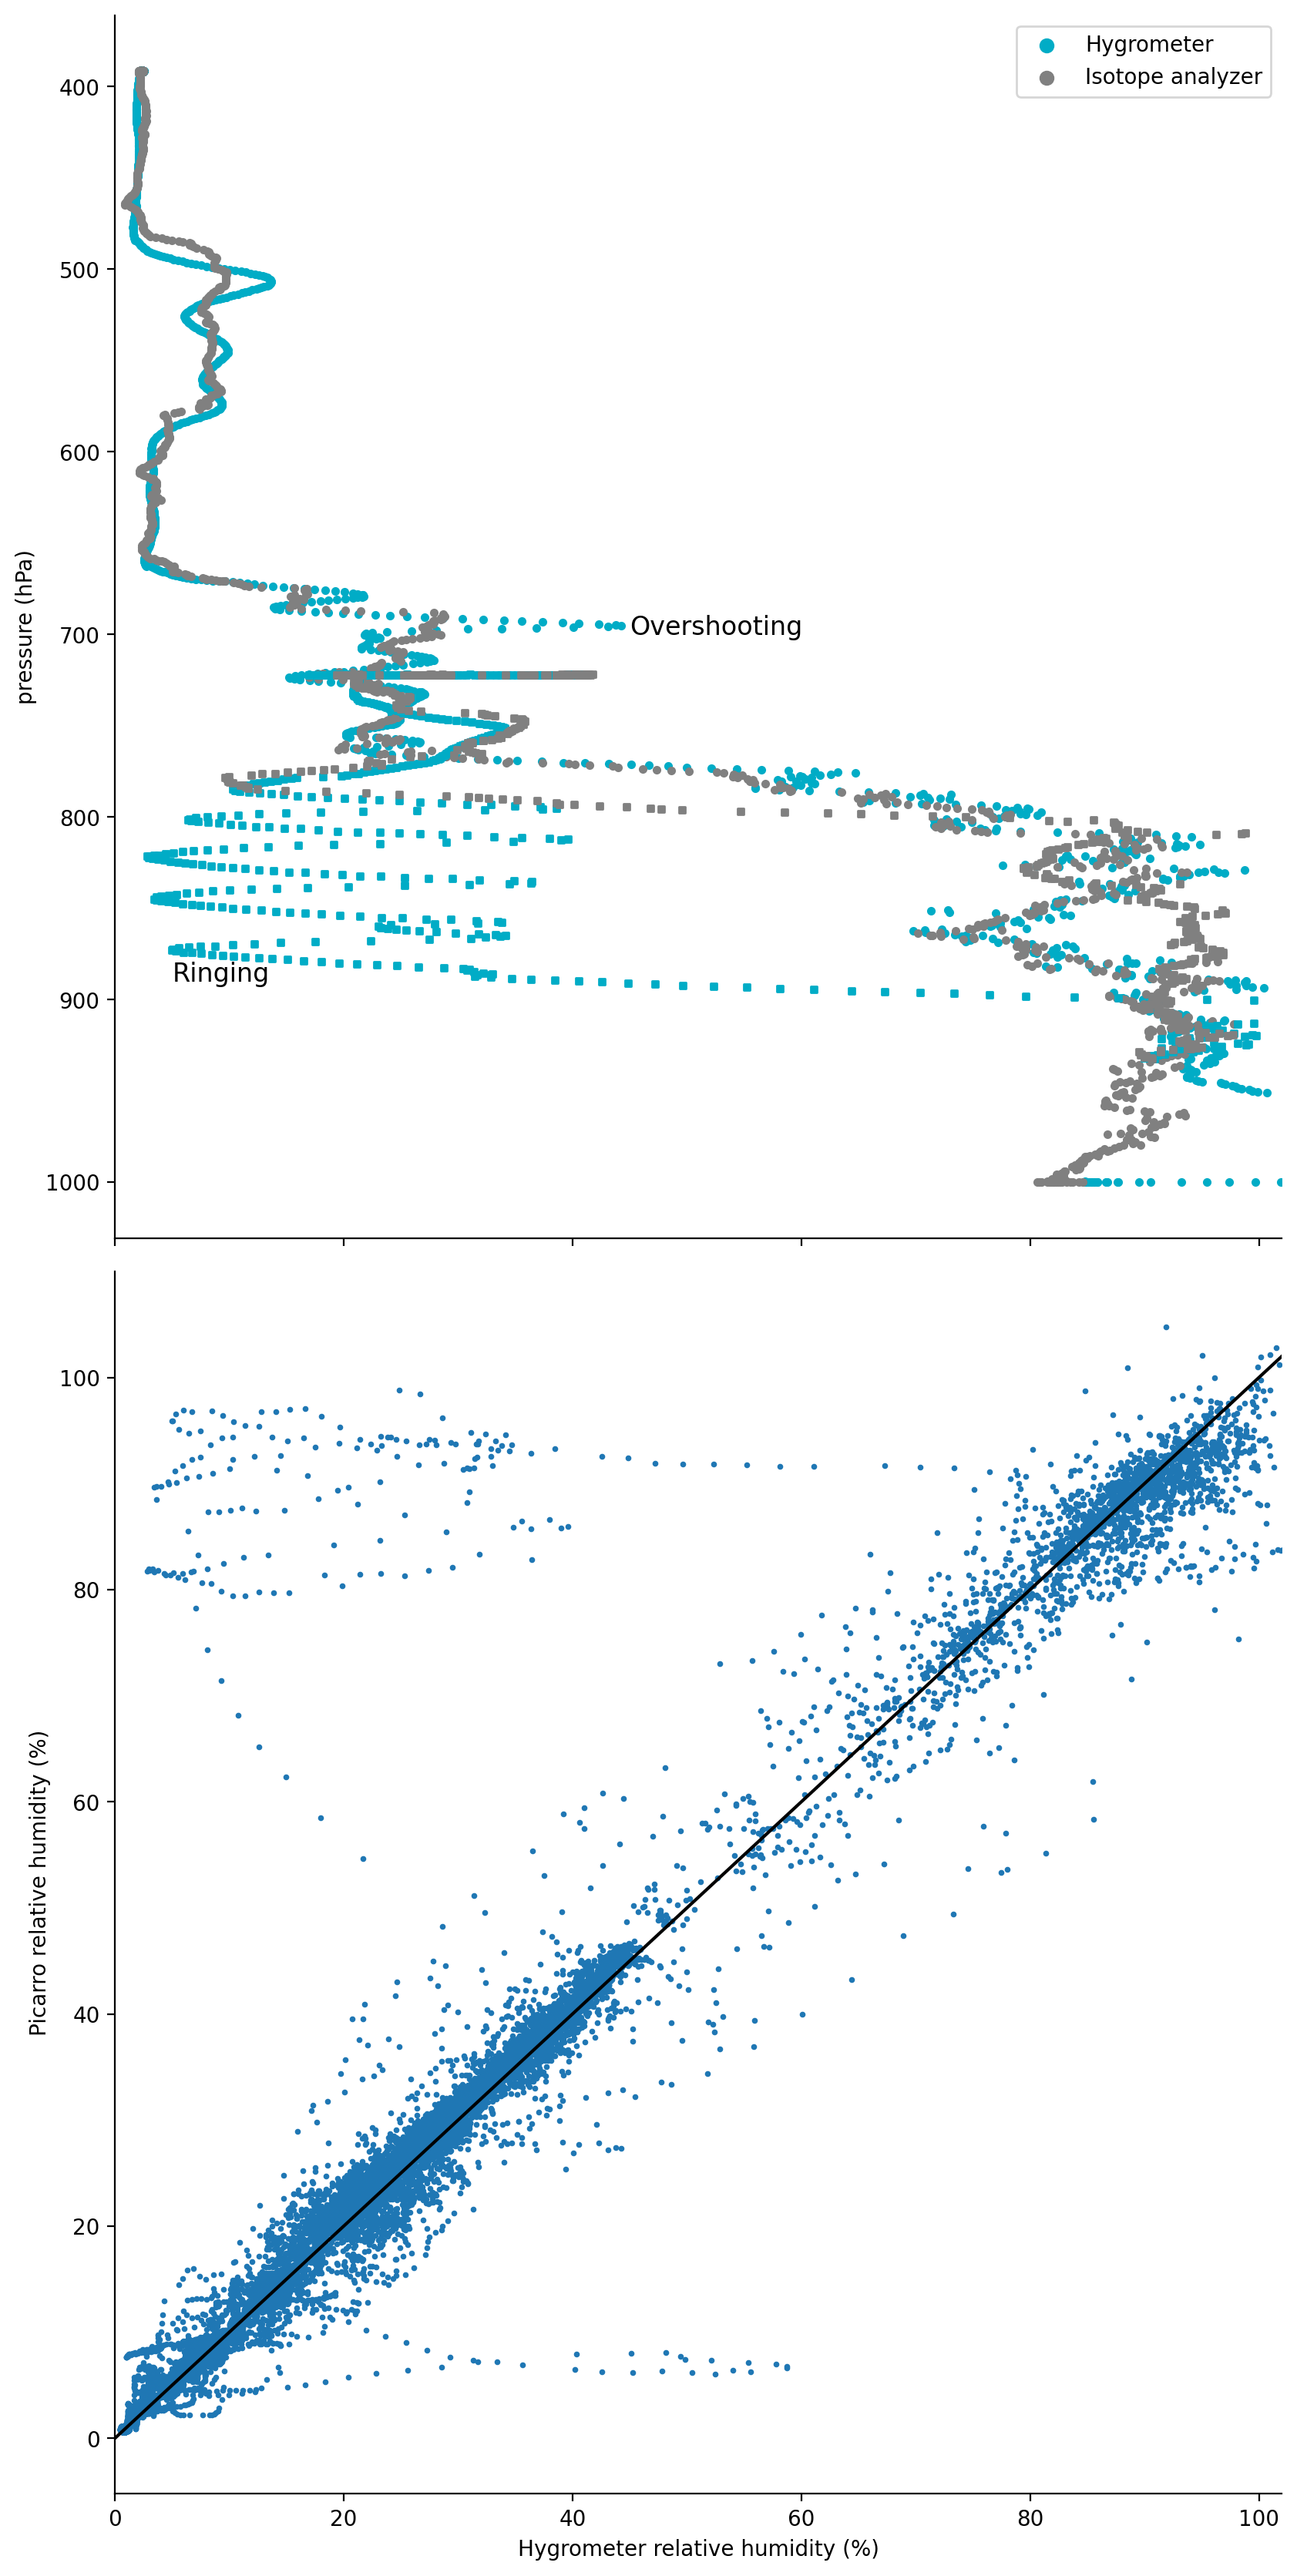

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex = True, figsize = (8.3, 16.6))
#
# One time window
#
profiles = rhs.sel(time = slice(np.datetime64("2020-01-19T15:36:00"),
                                np.datetime64("2020-01-19T16:07:40")))
marker = "."
ax1.scatter(profiles["rh_p3" ], profiles["press"],
           color=cc.glasbey[3], marker = marker, label = "Hygrometer")
ax1.scatter(profiles["rh_iso"], profiles["press"],
           color="0.5",         marker = marker, label = "Isotope analyzer")
#
# A second time window, shown as squares of roughly the same size
#
profiles = rhs.sel(time = slice(np.datetime64("2020-01-19T20:31:12"),
                                np.datetime64("2020-01-19T20:41:16")))
marker = "s"
ax1.scatter(profiles["rh_p3" ], profiles["press"],
           color=cc.glasbey[3], marker = marker, s = .2 * plt.rcParams['lines.markersize']**2)
ax1.scatter(profiles["rh_iso"], profiles["press"],
           color="0.5",         marker = marker, s = .2 * plt.rcParams['lines.markersize']**2)


ax1.invert_yaxis()
ax1.legend(markerscale = 2)
ax1.set_xlim(0, 100)
ax1.set_ylabel("pressure (hPa)")

ax1.annotate('Ringing',     ( 5,890), fontsize="large")
ax1.annotate('Overshooting',(45,700), fontsize="large")
#
# Picarro vs. hygrometer RH - they mostly agree
#
ax2.scatter(rhs["rh_p3"],rhs["rh_iso"], s=3)
# 1:1 line
ax2.plot([0,102], [0,102], color = 'black')
ax2.set_xlim(0, 102)
ax2.set_xlabel("Hygrometer relative humidity (%)")
ax2.set_ylabel("Picarro relative humidity (%)")